<a href="https://colab.research.google.com/github/majinmarco/LLMs/blob/main/Mistral_Trump_Edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U bitsandbytes # like tensorboard, used for easy to access stats
!pip install -q -U git+https://github.com/huggingface/transformers.git # huggingface api
!pip install -q -U git+https://github.com/huggingface/peft.git # used for Lora, speeds up fine- https://community.analyticsvidhya.com/c/generative-ai-tech-discussion/what-is-qlora
!pip install -q -U git+https://github.com/huggingface/accelerate.git # accelerates gpu
!pip install -q -U datasets scipy ipywidgets matplotlib fastapi kaleido python-multipart uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login
from google.colab import userdata
from google.colab import output
output.enable_custom_widget_manager()

from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
notebook_login() # logs into huggingdace

# Load in model


In [ ]:
!pip install -q wandb -U # will enable us to track model performance

import wandb, os
os.environ["WANDB_API_KEY"] = userdata.get('wandb_token')

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


# Prep dataset

## Tokenization, Model Instantiation

In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
) # this function enables quantization in the model, which reduces the model size by converting the model weights to low-precision floats, optimizing it so it uses les computing power

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(
            MODEL_NAME,
            padding_side="left",
            add_eos_token = True,
            add_bos_token=True) # tokenizer converts text data to numerical sequences that the model can understand. Padding makes training use less memory (zeros are passed which are not used)
            # model_max_length will be determined according to distribution of lengths in data

tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

## Dataset loading

In [ ]:
data = load_dataset("bananabot/TrumpSpeeches", split = 'train[1:]') # the split param is addressing an issue w an empty row, not necessary
data # get structure of data

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 7440
})

In [ ]:
data = data.train_test_split(test_size = 0.3) # split data into train and test
data # get new structure

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 5208
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2232
    })
})

In [ ]:
data["train"][0]

{'text': 'For years, patients have been shocked to receive unexpected bills for thousands of dollars in medical services they never agreed to. The first America First Healthcare Plan bans this deeply unfair practice. We will end surprise medical billing. The days of ripping off American patients are over. My plan also includes the vital reform of price transparency. Price transparency is great for the great doctors, the good doctors, and it’s also great for the great and good hospitals. That’s where it’s really fantastic for them too, in addition, obviously, to the patients. For the first time ever, we will create true competition in healthcare. Both hospitals and insurance companies will be required to post all of their prices online. This transformative policy will allow you to see your exact out-of-pocket cost before you go for treatment, making it easy to shop for the best price. Costs will come way down. Some people think this will have a bigger impact than healthcare itself. It’s

In [ ]:
data["test"][0]

{'text': 'Look at that. Oh, are they doing that on purpose? Are they friend or foe? I don’t know. Actually, it felt good. I felt water on my face. I said, “Where the hell is that coming from?” They may be doing that on purpose. Let’s find out if they’re friend or foe, and if their foe, let’s take care of those sons of bitches. Look at that. Are you okay? Oh, look, they’re hitting the press. That’s okay. Oh, there go the cameras. There goes a million dollars worth of equipment. Look at that. Wow. That’s cool, actually. And I’ll tell the media, “I have nothing to do with that,” but it is cooling. I’m feeling a little… It’s amazing. It’s amazing. And I say it all the time, because we’ve liked Ronald Reagan, we’ve liked a lot of… Mostly they’re stiffs. Mostly. Generally speaking, they don’t do the job. Right? But we’ve had good ones like Ronald Reagan. He’s the one I think about. But nobody ever chanted… First of all, he’d never get a crowd like this. He’d have two or 300 people, they’d be

In [ ]:
train = data["train"]
test = data["test"]

## Formatting to structure training data as promts so model has context

In [ ]:
def formatting_func(example):
    text = f"### The following is a speech by Donald Trump: {example['text']}"
    return text

In [ ]:
def generate_and_tokenize_prompt(prompt):
  return tokenizer(formatting_func(prompt))

In [ ]:
# these map the above functions to data. Format prompt to be followed by text data and then tokenizes it so the model can read it
train_tokenized = train.map(generate_and_tokenize_prompt)
test_tokenized = test.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/5208 [00:00<?, ? examples/s]

Map:   0%|          | 0/2232 [00:00<?, ? examples/s]

In [ ]:
train_tokenized

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 5208
})

In [ ]:
train_tokenized['input_ids'][0]

[1,
 774,
 415,
 2296,
 349,
 264,
 8666,
 486,
 14696,
 6932,
 28747,
 1263,
 1267,
 28725,
 6883,
 506,
 750,
 18809,
 298,
 5556,
 12799,
 16843,
 354,
 8577,
 302,
 9407,
 297,
 5714,
 3345,
 590,
 1484,
 5825,
 298,
 28723,
 415,
 907,
 4352,
 4205,
 6377,
 8001,
 9116,
 287,
 509,
 456,
 11869,
 25340,
 5245,
 28723,
 816,
 622,
 948,
 8982,
 5714,
 4875,
 288,
 28723,
 415,
 2202,
 302,
 3191,
 7319,
 805,
 2556,
 6883,
 460,
 754,
 28723,
 1984,
 2623,
 835,
 5532,
 272,
 12588,
 9861,
 302,
 4144,
 1203,
 23767,
 28723,
 11589,
 1203,
 23767,
 349,
 1598,
 354,
 272,
 1598,
 13500,
 28725,
 272,
 1179,
 13500,
 28725,
 304,
 378,
 28809,
 28713,
 835,
 1598,
 354,
 272,
 1598,
 304,
 1179,
 21737,
 28723,
 1725,
 28809,
 28713,
 970,
 378,
 28809,
 28713,
 1528,
 13762,
 354,
 706,
 1368,
 28725,
 297,
 4518,
 28725,
 9589,
 28725,
 298,
 272,
 6883,
 28723,
 1263,
 272,
 907,
 727,
 2270,
 28725,
 478,
 622,
 2231,
 1132,
 8995,
 297,
 15240,
 28723,
 7829,
 21737,
 304,
 691

7440


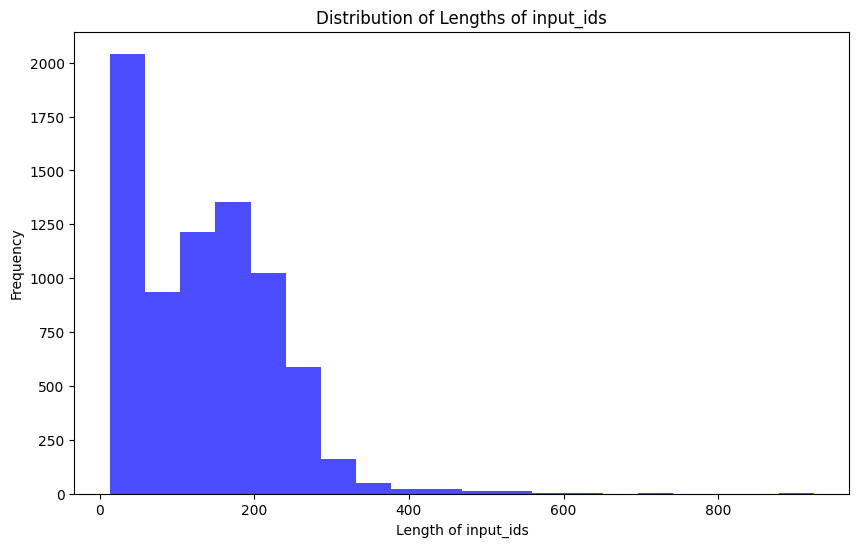

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(train_tokenized, test_tokenized)

500 seems to be a good cutoff of length. They are not very long anyways, which is good and will help the model.

In [ ]:
max_length = 500 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
train_tokenized = train.map(generate_and_tokenize_prompt2)
test_tokenized = test.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/5208 [00:00<?, ? examples/s]

Map:   0%|          | 0/2232 [00:00<?, ? examples/s]

With this, all samples should be of the same length. This is required for modeling in NLP/LLM tasks. Of course if data is shorter than the max length, there will be padding.

In [ ]:
print(train_tokenized[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

7440


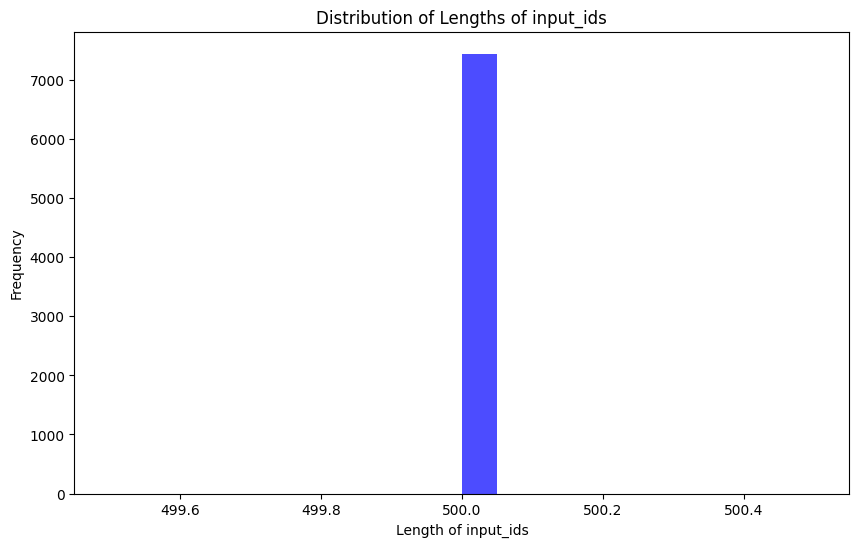

In [ ]:
plot_data_lengths(train_tokenized, test_tokenized)

Now they are all of one length 👍🏼

# Test original model

In [ ]:
eval_prompt = """
The following is a speech by Donald Trump: #
""".strip()

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad(): # utilized when purely testing a model
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The following is a speech by Donald Trump: #10.

“I’m going to be the greatest jobs president that God ever created.”

The following is a speech by Hillary Clinton: #9.

“We are stronger together, and we will rise together because we are always greater together than we are on our own.”

The following is a speech by Bernie Sanders: #8.

“This campaign is not about me or my candidacy. It’s about you and your future.”

The following is a speech by Ted Cruz: #7.

“If I am elected President, I will instruct the Department of Justice to open an investigation into the IRS targeting scandal.”

The following is a speech by Marco Rubio: #6.

“It’s time for us to take back this country from the people who have taken it away from us.”

The following is a speech by John Kasich: #5.

“I believe in America. And I know what makes America great.”

The following is a speech by Jeb Bush: #4.

“America needs a leader with a vision for the future, but also someone who understands how to get things done.”



# Set Up LoRA

In [ ]:
model.gradient_checkpointing_enable() # verifies that backpropagation calcs are correct
model = prepare_model_for_kbit_training(model) # prepares model for training

In [ ]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [ ]:
print(model) # shows layers in mistral. dont need to understand this. as it is highly complex

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

Here we define the LoRA config.

r is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

alpha is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were r=64 and lora_alpha=16, and these are said to generalize well, but we will use r=32 and lora_alpha=64 so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

(excerpt from https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb)

LoRA paper- https://arxiv.org/abs/2106.09685

In [ ]:
config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
      "q_proj",
      "k_proj",
      "v_proj",
      "o_proj",
      "gate_proj",
      "up_proj",
      "down_proj",
      "lm_head",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainables%: 2.2162799758751914


The trainable % is supposed to be low, since we are simply fine-tuning the model and we're not adding any more layers which (I believe) is conventional for lower-level LLMs.

In [ ]:
print(model) # see the difference

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

# Finetune the model

In [ ]:
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model = model,
    train_dataset = train_tokenized,
    eval_dataset = test_tokenized,
    args = transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,
        max_steps=100,
        num_train_epochs = 1,
        learning_rate=2.5e-4, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",    # ordinary optimizer
        logging_steps=1,             # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=10,               # Save checkpoints every 25 steps
        do_eval=True,                # Perform evaluation at the end of training
        evaluation_strategy ='steps',# Evaluate the model every logging step
        eval_steps = 10,             # Evaluation and Save happens every 10 steps
        save_total_limit = 5,        # Only last 5 models are saved. Older ones are deleted.
        load_best_model_at_end=True,
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}", # Name of the W&B run (optional)
        ),
    data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False), # batch data for training and apply padding
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss,Validation Loss
10,1.826500,2.001984
20,1.538600,2.029905
30,2.057300,2.049046
40,2.013800,2.019799
50,1.439600,1.968847
60,2.500300,1.969823
70,1.643900,1.956059
80,1.647000,1.953323
90,1.915800,1.938827
100,1.270600,1.928557


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=100, training_loss=1.8517815208435058, metrics={'train_runtime': 2262.6835, 'train_samples_per_second': 0.177, 'train_steps_per_second': 0.044, 'total_flos': 8634841497600000.0, 'train_loss': 1.8517815208435058, 'epoch': 0.08})

# Save trained model

In [ ]:
PEFT_MODEL = "marconardone/Mistral-7B-Trump-Edition"

model.push_to_hub(
    PEFT_MODEL
)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


adapter_model.safetensors:   0%|          | 0.00/865M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/marconardone/Mistral-7B-Trump-Edition/commit/4db1479df8399ec48a93f141d14e752958da8ce5', commit_message='Upload model', commit_description='', oid='4db1479df8399ec48a93f141d14e752958da8ce5', pr_url=None, pr_revision=None, pr_num=None)

# Run the finetuned model

In [ ]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
) # loads in bnb config from last time

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
) #loads in base model

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)
# new tokenizer with base model options like last time

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.repetition_penalty = 1.3
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.do_sample = True
generation_config.include_prompt_in_result = False

In [ ]:
fine_tuned_model = PeftModel.from_pretrained(base_model, PEFT_MODEL)

In [ ]:
eval_prompt = "The following is a speech by Donald Trump: # "
model_input = eval_tokenizer(eval_prompt, return_tensors = "pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
  outputs = model.generate(
      input_ids = model_input.input_ids,
      attention_mask = model_input.attention_mask,
      generation_config = generation_config,
  )

print(eval_tokenizer.decode(outputs[0], skip_special_tokens=True)+"[...]")

# fine_tuned_model.eval()
# with torch.no_grad():
#   print(eval_tokenizer.decode(fine_tuned_model.generate(**model_input, max_new_tokens=200, repetition_penalty=1.15)[0], skip_special_tokens=True))

The following is a speech by Donald Trump: # 2, we’re going to be doing the first ever President of United States visit. We will have more than one million people there for this event and it was put together very quickly. It was not easy because you know what? I don’t think anybody thought that they would get me as their president. So I want to thank everybody in India who worked so hard on making this possible. Thank you Prime Minister Modi for being here with us tonight. You are an incredible man and I am proud to call you my friend. And I look forward to working closely with you over these next four years. God bless America and god bless India.[...]


In [ ]:
def LLM_generator(topic):
  model_input = eval_tokenizer(f"The following is a speech by Donald Trump about {topic}: # ", return_tensors = "pt").to("cuda")

  fine_tuned_model.eval()
  with torch.no_grad():
    outputs = model.generate(
        input_ids = model_input.input_ids,
        attention_mask = model_input.attention_mask,
        generation_config = generation_config,
    )

  return eval_tokenizer.decode(outputs[0], skip_special_tokens=True)+"[...]"

In [ ]:
LLM_generator("China")

'The following is a speech by Donald Trump about China: # 1. We will not tolerate the theft of American jobs, and we’re going to put America first in every way possible. And that includes trade deals like NAFTA, which was just approved with some small changes, but it wasn’t good for us at all because they took our factories out. So I said no. They want to get rid of tariffs on Canada, right? Tariff free zone. No. It doesn’t work that way anymore. You can have your own country. But you cannot be taking advantage of other countries so easily. That won’t happen anymore. This isn’t what happens when somebody takes advantage of another nation. When people take advantage of this great country called the United States of America, there are consequences. There used to be very little consequence, but now those days are over. Nowadays if someone wants to mess around with us or try and beat up on us, it’s going to cost them more than ever[...]'

This model is not as flexible as I thought, but it definitely is very impressive. For example, I asked the bot to give me a speech about Ron De Santis, but every time I did it would not even mention him and talk about other things. However, this makes sense since my dataset may have been from his presidency where Ron De Santis was not as popular or the speeches that were in the dataset simply did not touch the subject. However, when I ask for a speech on China, one of his very popular topics for him, we get a very sensical and believable result.